In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%time
df_begin = pd.read_csv("total_district.txt",
                      names=['taxi_id','date_time','long','lat','district'])
df_begin['datetime'] = pd.to_datetime(df_begin['date_time'],format = '%Y-%m-%d %X')
df_begin = df_begin.set_index('datetime')
df_begin.drop(['long','lat','date_time'], axis = 1, inplace = True)
print(df_begin.head())

                     taxi_id  district
datetime                              
2008-02-02 15:36:08        1  Chaoyang
2008-02-02 15:46:08        1  Chaoyang
2008-02-02 15:46:08        1  Chaoyang
2008-02-02 15:56:08        1  Chaoyang
2008-02-02 16:06:08        1  Chaoyang
CPU times: user 1min 42s, sys: 2.57 s, total: 1min 45s
Wall time: 1min 46s


In [3]:
%%time
#Prevision for every 10 minutes
df = df_begin.groupby([pd.Grouper(level='datetime', freq='10Min'),
                      "district"])[['taxi_id']].count().reset_index()

CPU times: user 25.3 s, sys: 856 ms, total: 26.1 s
Wall time: 26.1 s


In [4]:
df.head()

,datetime,district,taxi_id
0,2008-02-02 13:30:00,Changping,72
1,2008-02-02 13:30:00,Chaoyang,4335
2,2008-02-02 13:30:00,Chongwen,2624
3,2008-02-02 13:30:00,Daxing,177
4,2008-02-02 13:30:00,Dongcheng,2808


In [5]:
df.shape

(15948, 3)

In [6]:
df.datetime = pd.to_datetime(df.datetime,format = '%Y-%m-%d %X')
df.columns=['datetime','district','taxi_count']

In [7]:
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate

In [8]:
res = requests.get("https://www.sunrise-and-sunset.com/en/sun/china/beijing/2008/february/2")
soup = BeautifulSoup(res.content,'lxml')
all_tables=soup.find_all("table")

In [9]:
df_sunrise = pd.read_html(str(all_tables[1]))[0][1:8].reset_index()

In [10]:
df_sunrise.drop('index',axis=1,inplace=True)

/home/pranav/.local/lib/python3.5/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [11]:
df_sunrise.columns=["Day","Sunrise","Sunset","Day Lenght"]

In [12]:
df_sunrise

,Day,Sunrise,Sunset,Day Lenght
0,"2 February 2008, Saturday",07:23,17:32,10:09
1,"3 February 2008, Sunday",07:22,17:34,10:11
2,"4 February 2008, Monday",07:21,17:35,10:13
3,"5 February 2008, Tuesday",07:20,17:36,10:15
4,"6 February 2008, Wednesday",07:19,17:37,10:17
5,"7 February 2008, Thursday",07:18,17:38,10:20
6,"8 February 2008, Friday",07:17,17:40,10:22


In [13]:
df_sunrise = pd.concat([df_sunrise,pd.DataFrame([day.split(',') for day in df_sunrise.Day])],
                        axis=1,ignore_index=True)
df_sunrise.columns=["Day","Sunrise","Sunset","Day Length","Date","WeekDay"]
df_sunrise.Date = pd.to_datetime(df_sunrise.Date)

In [14]:
df_sunrise.Date = pd.to_datetime(df_sunrise.Date)

In [15]:
df_sunrise

,Day,Sunrise,Sunset,Day Length,Date,WeekDay
0,"2 February 2008, Saturday",07:23,17:32,10:09,2008-02-02,Saturday
1,"3 February 2008, Sunday",07:22,17:34,10:11,2008-02-03,Sunday
2,"4 February 2008, Monday",07:21,17:35,10:13,2008-02-04,Monday
3,"5 February 2008, Tuesday",07:20,17:36,10:15,2008-02-05,Tuesday
4,"6 February 2008, Wednesday",07:19,17:37,10:17,2008-02-06,Wednesday
5,"7 February 2008, Thursday",07:18,17:38,10:20,2008-02-07,Thursday
6,"8 February 2008, Friday",07:17,17:40,10:22,2008-02-08,Friday


In [16]:
#Just save it in case the site goes down we have a backup
#df_sunrise.to_csv("sunrise_timing_beijing.csv",index=None)

In [17]:
def is_sun_up(data,sunrise_table):
    detail  = sunrise_table[data.date()==sunrise_table.Date.dt.date].reset_index()
    sunrise = pd.to_datetime(detail['Date'].dt.date.apply(str)+" "+detail['Sunrise'])
    sunset  = pd.to_datetime(detail['Date'].dt.date.apply(str)+" "+detail['Sunset'])
    if ((sunrise < data) & (data < sunset))[0]:
        return 1
    else:
        return 0

In [18]:
def day_period(time):
    hour = time.hour
    if(0<=hour<=5 or hour>=23):
        return "Night"
    if(6<=hour<=12):
        return "Morning"
    if(12<hour<=18):
        return "Afternoon"
    if(18<hour<23):
        return "Evening"
    
def is_time_to_eat(time):
    hour = time.hour
    if(6<=hour<=9 or 12<=hour<=14 or 18<=hour<=21):
        return 1 #yes
    else:
        return 0 #no

In [19]:
#%%time
#df["period"] = df.datetime.apply(day_period)
#I find more interesting this way, atleast there is some data behind it to
#justify, defining the Morning, Evening like we did before cannot be easily
#justified.
#df["is_sun_up"]  = df.datetime.apply(lambda x: is_sun_up(x,df_sunrise)) 
#df["time_to_eat"] = df.datetime.apply(is_time_to_eat)

In [20]:
#In the LSTM I don't actually need it the extra variable,
#just keeping them in case you guys need it
df.head(20)

,datetime,district,taxi_count
0,2008-02-02 13:30:00,Changping,72
1,2008-02-02 13:30:00,Chaoyang,4335
2,2008-02-02 13:30:00,Chongwen,2624
3,2008-02-02 13:30:00,Daxing,177
4,2008-02-02 13:30:00,Dongcheng,2808
5,2008-02-02 13:30:00,Fangshan,82
6,2008-02-02 13:30:00,Fengtai,2035
7,2008-02-02 13:30:00,Haidian,2209
8,2008-02-02 13:30:00,Huairou,14
9,2008-02-02 13:30:00,Mentougou,21


In [21]:
time_series = df.groupby('datetime')['taxi_count'].sum()

In [22]:
time_series = pd.DataFrame(time_series).reset_index()

In [23]:
%%time
time_series["is_sun_up"]  = time_series.datetime.apply(lambda x: is_sun_up(x,df_sunrise)) 
time_series["time_to_eat"] = time_series.datetime.apply(is_time_to_eat)

CPU times: user 5.06 s, sys: 24 ms, total: 5.09 s
Wall time: 5.12 s


In [24]:
time_series.set_index('datetime',inplace=True)

In [25]:
time_series.head()

,taxi_count,is_sun_up,time_to_eat
datetime,,,
2008-02-02 13:30:00,19721,1,1
2008-02-02 13:40:00,28444,1,1
2008-02-02 13:50:00,28627,1,1
2008-02-02 14:00:00,25055,1,1
2008-02-02 14:10:00,24114,1,1


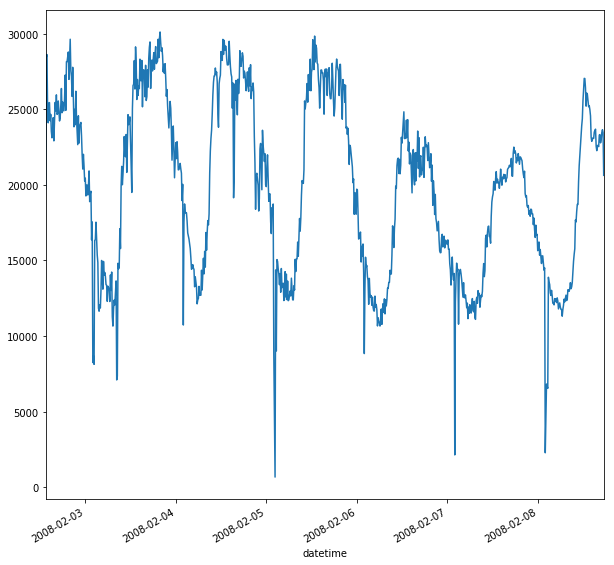

In [26]:
plt.figure(figsize=(10, 10))
time_series.taxi_count.plot()
plt.show()

In [27]:
import plotly.plotly as py
import cufflinks as cf

py.iplot([{
    'x': time_series.index,
    'y': time_series.taxi_count
}])

/home/pranav/.local/lib/python3.5/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



# Here is the LSTM

In [28]:
#This is the one we will use for the forcasting
time_series_simple = time_series.iloc[:,0:1].values

In [29]:
#Splitting the training and the test set,
#We keep the last 150 observations for testing
train, test = time_series_simple[6:-80], time_series_simple[-80:]

In [30]:
#Just checking the dimensions
train.shape

(800, 1)

In [31]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [32]:
scaler = MinMaxScaler(feature_range=(0,1))
#They work better in this range (0,1)
#We fit according to the traning set, since we
#assume not to have access to the test set
train_scaled = scaler.fit_transform(train) 

In [33]:
#Just double checking
train_scaled[1:5]

array([[0.80078748],
       [0.81490784],
       [0.77638234],
       [0.76219409]])

In [34]:
#number of records to use to predict the future.
old_record_number=80

In [35]:
features_set = []  
labels = []  
#Use N=old_record_number to predict to next one
#we create the N features for the Neurons inputs and
# the label contain the y values
#so basically a x_train and a y_train
for i in range(old_record_number, len(train_scaled)):  
    features_set.append(train_scaled[i-old_record_number:i, 0])
    labels.append(train_scaled[i, 0])

In [36]:
# We need them as np array
features_set, labels = np.array(features_set), np.array(labels)  

In [37]:
#Reshape them according to what LSTM wants:
# - A three dimensional array where the:
#   - first dim is the number of records
#   - second dim is the number of steps (old_record_number)
#   - third dim is the number of variabiles (for us 1, since we use only the taxi_count)
features_set = np.reshape(features_set, 
                          (features_set.shape[0], 
                           features_set.shape[1], 
                           1))  #Using only one feature

In [38]:
features_set.shape

(720, 80, 1)

In [39]:
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense  
from tensorflow.keras.layers import LSTM  
from tensorflow.keras.layers import Dropout 

In [172]:
import ipdb

In [176]:
class LSTM_3_NN():
    """This is a LSTM NN, it take in input a vector containing prende the units of 
    LSTM (only 3), the drop parameter to avoid overfitting, batch size and the
    training set divided into x_train and y_train"""
    def __init__(self,units,drop,epochs,batch_size,x_train,y_train):
        "The function compiles and fits the neural network"
        self.units = units
        self.shape_1 = x_train.shape[1]
        self.shape_2 = x_train.shape[2]
        self.drop  = drop
        self.model = Sequential()
        self.create_model()
        self.epochs=epochs
        self.batch_size = batch_size
        self.fit(x_train,y_train)
        
    def create_model(self):
        "Create the actual NN"
        #units is the number of neurons, return_sequences is True because 
        #we will use more layers
        self.model.add(LSTM(units=self.units[0],return_sequences=True,
                 input_shape = (self.shape_1,self.shape_2)))
        self.model.add(Dropout(self.drop[1])) #avoids overfitting
        
        #Deep LSTM
        self.model.add(LSTM(units=self.units[1],return_sequences=True))
        self.model.add(Dropout(self.drop[1]))
        
        self.model.add(LSTM(units=self.units[2]))
        self.model.add(Dropout(self.drop[2]))
        
        self.model.add(Dense(units=1))#output layer
        #use rmsprop as optimizer and mse as the metrics, the loss is MAE
        self.model.compile(optimizer = 'rmsprop', loss = 'mean_absolute_error',
                          metrics=['mse'])
        
    def fit(self,X_train,y_train):
        "Fitting the model with the training set"
        #remember the batch size must divide the training and the test size
        self.model.fit(X_train,y_train,
                       epochs=self.epochs,batch_size=self.batch_size)
    def predict(self,x_test):
        "return the prediction of the test set"
        return(self.model.predict(x_test))

In [177]:
modello = LSTM_3_NN(units=[80,80,80],drop=[0.1,0.1,0.2],epochs=100,
                    batch_size=40,x_train=features_set,y_train=labels)

Epoch 1/100
720/720 [==============================] - 8s 10ms/sample - loss: 0.2239 - mean_squared_error: 0.1431
Epoch 2/100
720/720 [==============================] - 5s 7ms/sample - loss: 0.1340 - mean_squared_error: 0.0280
Epoch 3/100
720/720 [==============================] - 5s 6ms/sample - loss: 0.1177 - mean_squared_error: 0.0228
Epoch 4/100
720/720 [==============================] - 5s 7ms/sample - loss: 0.1177 - mean_squared_error: 0.0224
Epoch 5/100
720/720 [==============================] - 5s 7ms/sample - loss: 0.1096 - mean_squared_error: 0.0196
Epoch 6/100
720/720 [==============================] - 5s 7ms/sample - loss: 0.0936 - mean_squared_error: 0.0150
Epoch 7/100
720/720 [==============================] - 5s 7ms/sample - loss: 0.1020 - mean_squared_error: 0.0164
Epoch 8/100
720/720 [==============================] - 5s 7ms/sample - loss: 0.0974 - mean_squared_error: 0.0158
Epoch 9/100
720/720 [==============================] - 5s 7ms/sample - loss: 0.0973 - mean_squa

720/720 [==============================] - 5s 7ms/sample - loss: 0.0515 - mean_squared_error: 0.0053
Epoch 73/100
720/720 [==============================] - 5s 7ms/sample - loss: 0.0550 - mean_squared_error: 0.0059
Epoch 74/100
720/720 [==============================] - 5s 7ms/sample - loss: 0.0517 - mean_squared_error: 0.0053
Epoch 75/100
720/720 [==============================] - 5s 6ms/sample - loss: 0.0519 - mean_squared_error: 0.0053
Epoch 76/100
720/720 [==============================] - 5s 7ms/sample - loss: 0.0504 - mean_squared_error: 0.0050
Epoch 77/100
720/720 [==============================] - 5s 7ms/sample - loss: 0.0549 - mean_squared_error: 0.0058
Epoch 78/100
720/720 [==============================] - 5s 7ms/sample - loss: 0.0509 - mean_squared_error: 0.0051
Epoch 79/100
720/720 [==============================] - 5s 7ms/sample - loss: 0.0529 - mean_squared_error: 0.0056
Epoch 80/100
720/720 [==============================] - 5s 7ms/sample - loss: 0.0511 - mean_squared_e

In [178]:
predictions = modello.predict(test_features)

In [112]:
test.shape

(80, 1)

In [113]:
time_series_simple.shape

(886, 1)

In [114]:
#We need it later as test inputs (no the values but the series itself)
total = time_series['taxi_count'].iloc[6:886]

In [115]:
total.shape

(880,)

In [116]:
test_inputs = total[len(total)-len(test)-old_record_number:].values

In [117]:
test_inputs = test_inputs.reshape(-1,1)

In [118]:
test_inputs = scaler.transform(test_inputs)

In [119]:
test_features = []  
for i in range(old_record_number, len(test_inputs)):  
    test_features.append(test_inputs[i-old_record_number:i, 0])

In [121]:
test_features = np.array(test_features)

In [122]:
test_features = np.reshape(test_features, 
                           (test_features.shape[0], 
                            test_features.shape[1], 
                            1))  

In [123]:
test_features.shape

(80, 80, 1)

In [179]:
predictions = scaler.inverse_transform(predictions)

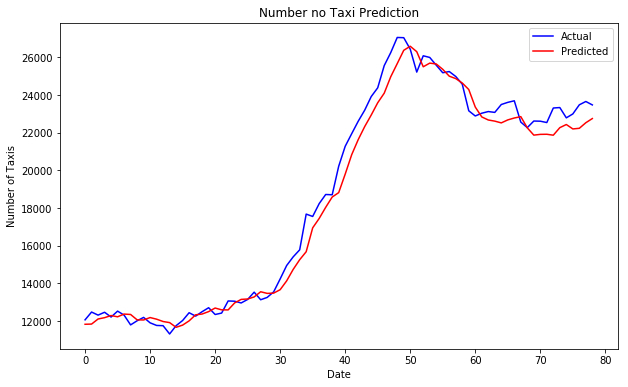

In [180]:
plt.figure(figsize=(10,6))  
plt.plot(test[0:79], color='blue', label='Actual')  
plt.plot(predictions[0:79] , color='red', label='Predicted')  
plt.title('Number no Taxi Prediction')  
plt.xlabel('Date')  
plt.ylabel('Number of Taxis')  
plt.legend()  
plt.show()  

In [181]:
np.mean(np.abs((predictions[0:test.shape[0]-1]-test[0:test.shape[0]-1])/test[0:test.shape[0]-1]))

0.028743010455359173

In [182]:
from sklearn.metrics import r2_score
r2_score(test[0:79],predictions[0:79])

0.9834051092579709

In [186]:
over = modello.predict(features_set)
over = scaler.inverse_transform(over)

In [193]:
train_ = scaler.inverse_transform(labels.reshape(-1,1))

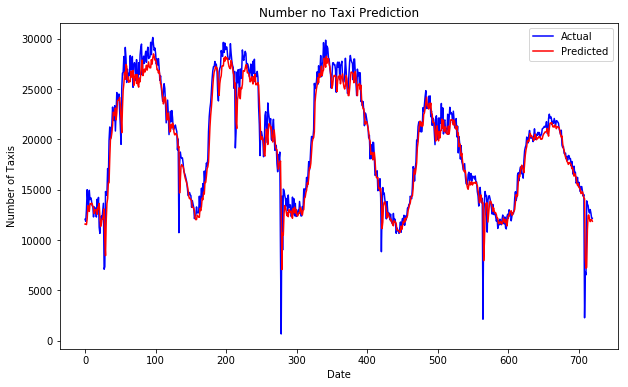

In [195]:
plt.figure(figsize=(10,6))  
plt.plot(train[80:], color='blue', label='Actual')  
plt.plot(over , color='red', label='Predicted')  
plt.title('Number no Taxi Prediction')  
plt.xlabel('Date')  
plt.ylabel('Number of Taxis')  
plt.legend()  
plt.show()  

In [199]:
np.mean(np.abs((train[80:]-over)/train[80:]))

0.09487888044559992

In [198]:
r2_score(train[80:],over)

0.9195184721509481